In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from helpers import *
import numpy as np
from IPython import embed

In [19]:
data = [ 
    'data/liquor.json',
    'data/social_cocktail.json',
    'data/serious_eats.json',
    'data/live_in_style.json',
    'data/all_recipes.json'
]

descriptions, ingredients, names = [], [], []

for d in data:
    descriptions += load_data(d, field='description')
    ingredients += load_data(d, field='ingredients')
    names += load_data(d, field='name')

assert len(descriptions) == len(ingredients)

recipes = [x + ' # ' + y for x, y in zip(ingredients, descriptions)]    
print('There are {} recipes in the database.'.format(len(recipes)))

There are 3347 recipes in the database.


In [20]:
limit = 1000

filter_words = ['s', 'o']

T = [clean_string(x) for x in ingredients]
T = sentences_to_words(T)
fT = [item for sublist in T for item in sublist]
vT = Counter(fT).most_common(limit)
vT = set([x[0] for x in vT if x[0] not in filter_words])

for i,t in enumerate(T):
    T[i] = [x for x in t if x in vT]

N = [clean_string(x) for x in names]
N = [x.split() for x in N]
fN = [item for sublist in N for item in sublist]
vN = Counter(fN).most_common(limit)
vN = set([x[0] for x in vN if x[0] not in filter_words])

for i,n in enumerate(N):
    N[i] = [x for x in n if x in vN]


rIngr = []
rNames = []
# c = 0
# tot = 0

# for t in T:
#     if(len(t)>20):
#         c+=1
#     tot+=1
    
# print(c,tot)

for i,t in enumerate(T):
    if len(T[i]) <= 20 and len(T[i]) > 0 and len(N[i]) <= 5 and len(N[i]) > 0:
        rIngr = rIngr + [T[i]]
        rNames = rNames + [N[i]]
    
rIngr = [np.append(x, ["null"]*(20-len(x))) for x in rIngr]
rNames = [np.append(x, ["null"]*(5-len(x))) for x in rNames]

rIngr = np.array(rIngr)
rNames = np.array(rNames)

In [21]:
print(rIngr.shape)
print(rNames.shape)

(2807, 20)
(2807, 5)


In [22]:
print(rIngr[123])
print(rNames[123])

['worcestershire' 'sauce' 'celery' 'juice' 'taste' 'tabasco' 'horseradish'
 'vodka' 'prepared' 'clamato' 'optional' 'null' 'null' 'null' 'null' 'null'
 'null' 'null' 'null' 'null']
['bloody' 'caesar' 'null' 'null' 'null']


In [23]:
label_encoder_names = LabelEncoder()
label_encoder_ingrs = LabelEncoder()


label_encoder_names.fit(rNames.flatten())
label_encoder_ingrs.fit(rIngr.flatten())

encoded_names = label_encoder_names.transform([[x] for x in list(set(rNames.flatten()))])
encoded_ingrs = label_encoder_ingrs.transform([[x] for x in list(set(rIngr.flatten()))])

onehot_encoder_names = OneHotEncoder(sparse=False)
onehot_encoder_ingrs = OneHotEncoder(sparse=False)

onehot_encoder_names.fit(encoded_names.reshape(-1,1))
onehot_encoder_ingrs.fit(encoded_ingrs.reshape(-1,1))

fIngr = []
fNames = []

for i,_ in enumerate(rNames):
    fIngr += [np.array(onehot_encoder_ingrs.transform(label_encoder_ingrs.transform(rIngr[i]).reshape(-1,1))).flatten()]
    fNames += [np.array(onehot_encoder_names.transform(label_encoder_names.transform(rNames[i]).reshape(-1,1))).flatten()]
    
X = np.array(fIngr)
y = np.array(fNames)

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
# N = X.shape[0]
# X_train, y_train = X[:int(N*0.95)], y[:int(N*0.95)]
# X_val, y_val = X[int(N*0.95):], y[int(N*0.95):]

from sklearn.model_selection import train_test_split
X_train, X_val, y_tr, y_v = train_test_split(X, y, test_size=0.1)

y_tr = y_tr.reshape(y_tr.shape[0], 5, int(y_tr.shape[1]/5))
y_v = y_v.reshape(y_v.shape[0], 5, int(y_v.shape[1]/5))

y_train = []
for i in range(5):
    y_train.append(y_tr[:,i,:])
    
y_val = []
for i in range(5):
    y_val.append(y_v[:,i,:])

    
# y_train = np.array(y_train)
# y_val = np.array(y_val)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

In [25]:
import numpy as np
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import random

Using TensorFlow backend.


In [41]:
inputs = Input(shape=(X.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

outputs = []
for i in range(5):
    outputs.append(Dense(int(y.shape[1]/5), activation='softmax', name='output'+str(i))(x))

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 19340)        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          2475648     input_4[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           8256        dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           4160        dense_7[0][0]                    
__________________________________________________________________________________________________
output0 (D

In [42]:
epochs = [10, 50, 100]
batch_size = 100

for e in epochs:
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=e, batch_size=batch_size,verbose=1)
    
#     print(a.history[e-1])
    for i in range(10):
        ent = random.randint(0,len(X_train))
        predict = X_train[ent]
        
        p = model.predict(x=np.array([predict]),batch_size=batch_size)
        p = np.array(p)
        p = p.reshape(5,int(y.shape[1]/5))
        b = np.zeros_like(p)
        b[np.arange(len(p)), p.argmax(1)] = 1
        decoded = b.dot(onehot_encoder_names.active_features_).astype(int)
        result = label_encoder_names.inverse_transform(decoded)


        print(rIngr[ent])
        print(rNames[ent])
        print(result)
        print('')

Train on 2526 samples, validate on 281 samples
Epoch 1/10
2526/2526 [==============================] - 9s 3ms/step - loss: 31.3512 - output0_loss: 6.7824 - output1_loss: 6.5187 - output2_loss: 6.1849 - output3_loss: 5.9894 - output4_loss: 5.8758 - output0_categorical_accuracy: 0.0059 - output1_categorical_accuracy: 0.1394 - output2_categorical_accuracy: 0.3935 - output3_categorical_accuracy: 0.5982 - output4_categorical_accuracy: 0.7375 - val_loss: 20.6993 - val_output0_loss: 6.5872 - val_output1_loss: 5.4125 - val_output2_loss: 3.7851 - val_output3_loss: 2.6676 - val_output4_loss: 2.2469 - val_output0_categorical_accuracy: 0.0178 - val_output1_categorical_accuracy: 0.2420 - val_output2_categorical_accuracy: 0.6263 - val_output3_categorical_accuracy: 0.8754 - val_output4_categorical_accuracy: 0.9609
Epoch 2/10
2526/2526 [==============================] - 7s 3ms/step - loss: 16.3972 - output0_loss: 6.4759 - output1_loss: 5.4040 - output2_loss: 2.7407 - output3_loss: 1.2289 - output4_los

2526/2526 [==============================] - 7s 3ms/step - loss: 12.5001 - output0_loss: 5.6584 - output1_loss: 4.3097 - output2_loss: 1.7866 - output3_loss: 0.5882 - output4_loss: 0.1573 - output0_categorical_accuracy: 0.0724 - output1_categorical_accuracy: 0.2621 - output2_categorical_accuracy: 0.6552 - output3_categorical_accuracy: 0.8895 - output4_categorical_accuracy: 0.9640 - val_loss: 16.5589 - val_output0_loss: 6.7189 - val_output1_loss: 5.5142 - val_output2_loss: 2.8404 - val_output3_loss: 1.1403 - val_output4_loss: 0.3451 - val_output0_categorical_accuracy: 0.0712 - val_output1_categorical_accuracy: 0.2598 - val_output2_categorical_accuracy: 0.6263 - val_output3_categorical_accuracy: 0.8292 - val_output4_categorical_accuracy: 0.9609
Epoch 2/50
2526/2526 [==============================] - 7s 3ms/step - loss: 11.9911 - output0_loss: 5.5090 - output1_loss: 4.1314 - output2_loss: 1.6705 - output3_loss: 0.5405 - output4_loss: 0.1398 - output0_categorical_accuracy: 0.0839 - output1

Epoch 12/50
2526/2526 [==============================] - 7s 3ms/step - loss: 5.6910 - output0_loss: 2.9079 - output1_loss: 1.9122 - output2_loss: 0.6484 - output3_loss: 0.1778 - output4_loss: 0.0446 - output0_categorical_accuracy: 0.3610 - output1_categorical_accuracy: 0.5566 - output2_categorical_accuracy: 0.8337 - output3_categorical_accuracy: 0.9497 - output4_categorical_accuracy: 0.9869 - val_loss: 24.0104 - val_output0_loss: 8.9897 - val_output1_loss: 7.8080 - val_output2_loss: 4.5990 - val_output3_loss: 2.0381 - val_output4_loss: 0.5755 - val_output0_categorical_accuracy: 0.0534 - val_output1_categorical_accuracy: 0.1601 - val_output2_categorical_accuracy: 0.5516 - val_output3_categorical_accuracy: 0.8043 - val_output4_categorical_accuracy: 0.9537
Epoch 13/50
2526/2526 [==============================] - 7s 3ms/step - loss: 5.1356 - output0_loss: 2.6444 - output1_loss: 1.7177 - output2_loss: 0.5834 - output3_loss: 0.1501 - output4_loss: 0.0400 - output0_categorical_accuracy: 0.393

Epoch 23/50
2526/2526 [==============================] - 7s 3ms/step - loss: 1.7555 - output0_loss: 0.9404 - output1_loss: 0.5815 - output2_loss: 0.1845 - output3_loss: 0.0383 - output4_loss: 0.0108 - output0_categorical_accuracy: 0.7886 - output1_categorical_accuracy: 0.8741 - output2_categorical_accuracy: 0.9561 - output3_categorical_accuracy: 0.9929 - output4_categorical_accuracy: 0.9964 - val_loss: 29.4171 - val_output0_loss: 11.0836 - val_output1_loss: 9.7220 - val_output2_loss: 5.6162 - val_output3_loss: 2.3737 - val_output4_loss: 0.6216 - val_output0_categorical_accuracy: 0.0534 - val_output1_categorical_accuracy: 0.1566 - val_output2_categorical_accuracy: 0.5018 - val_output3_categorical_accuracy: 0.8007 - val_output4_categorical_accuracy: 0.9537
Epoch 24/50
2526/2526 [==============================] - 7s 3ms/step - loss: 1.5621 - output0_loss: 0.8341 - output1_loss: 0.5217 - output2_loss: 0.1622 - output3_loss: 0.0354 - output4_loss: 0.0087 - output0_categorical_accuracy: 0.82

Epoch 34/50
2526/2526 [==============================] - 7s 3ms/step - loss: 0.5713 - output0_loss: 0.2994 - output1_loss: 0.1974 - output2_loss: 0.0576 - output3_loss: 0.0133 - output4_loss: 0.0036 - output0_categorical_accuracy: 0.9466 - output1_categorical_accuracy: 0.9628 - output2_categorical_accuracy: 0.9893 - output3_categorical_accuracy: 0.9972 - output4_categorical_accuracy: 0.9992 - val_loss: 31.6159 - val_output0_loss: 12.1880 - val_output1_loss: 10.5927 - val_output2_loss: 5.8023 - val_output3_loss: 2.4052 - val_output4_loss: 0.6277 - val_output0_categorical_accuracy: 0.0498 - val_output1_categorical_accuracy: 0.1352 - val_output2_categorical_accuracy: 0.5231 - val_output3_categorical_accuracy: 0.8185 - val_output4_categorical_accuracy: 0.9573
Epoch 35/50
2526/2526 [==============================] - 7s 3ms/step - loss: 0.5253 - output0_loss: 0.2741 - output1_loss: 0.1813 - output2_loss: 0.0549 - output3_loss: 0.0116 - output4_loss: 0.0034 - output0_categorical_accuracy: 0.9

Epoch 45/50
2526/2526 [==============================] - 7s 3ms/step - loss: 0.2369 - output0_loss: 0.1165 - output1_loss: 0.0851 - output2_loss: 0.0256 - output3_loss: 0.0063 - output4_loss: 0.0033 - output0_categorical_accuracy: 0.9830 - output1_categorical_accuracy: 0.9857 - output2_categorical_accuracy: 0.9945 - output3_categorical_accuracy: 0.9988 - output4_categorical_accuracy: 0.9992 - val_loss: 33.2552 - val_output0_loss: 12.7284 - val_output1_loss: 11.1691 - val_output2_loss: 6.2138 - val_output3_loss: 2.4911 - val_output4_loss: 0.6527 - val_output0_categorical_accuracy: 0.0427 - val_output1_categorical_accuracy: 0.1068 - val_output2_categorical_accuracy: 0.4911 - val_output3_categorical_accuracy: 0.8149 - val_output4_categorical_accuracy: 0.9502
Epoch 46/50
2526/2526 [==============================] - 7s 3ms/step - loss: 0.2153 - output0_loss: 0.1053 - output1_loss: 0.0801 - output2_loss: 0.0223 - output3_loss: 0.0053 - output4_loss: 0.0024 - output0_categorical_accuracy: 0.9

2526/2526 [==============================] - 4s 2ms/step - loss: 0.1563 - output0_loss: 0.0738 - output1_loss: 0.0578 - output2_loss: 0.0190 - output3_loss: 0.0040 - output4_loss: 0.0019 - output0_categorical_accuracy: 0.9889 - output1_categorical_accuracy: 0.9889 - output2_categorical_accuracy: 0.9960 - output3_categorical_accuracy: 0.9988 - output4_categorical_accuracy: 0.9992 - val_loss: 33.7004 - val_output0_loss: 12.9647 - val_output1_loss: 11.3384 - val_output2_loss: 6.2329 - val_output3_loss: 2.5152 - val_output4_loss: 0.6490 - val_output0_categorical_accuracy: 0.0498 - val_output1_categorical_accuracy: 0.1246 - val_output2_categorical_accuracy: 0.5018 - val_output3_categorical_accuracy: 0.8149 - val_output4_categorical_accuracy: 0.9502
Epoch 3/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.1495 - output0_loss: 0.0692 - output1_loss: 0.0565 - output2_loss: 0.0174 - output3_loss: 0.0038 - output4_loss: 0.0026 - output0_categorical_accuracy: 0.9893 - output

Epoch 13/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.1148 - output0_loss: 0.0516 - output1_loss: 0.0427 - output2_loss: 0.0147 - output3_loss: 0.0035 - output4_loss: 0.0023 - output0_categorical_accuracy: 0.9893 - output1_categorical_accuracy: 0.9897 - output2_categorical_accuracy: 0.9960 - output3_categorical_accuracy: 0.9992 - output4_categorical_accuracy: 0.9988 - val_loss: 34.5574 - val_output0_loss: 13.1561 - val_output1_loss: 11.6149 - val_output2_loss: 6.4794 - val_output3_loss: 2.6480 - val_output4_loss: 0.6590 - val_output0_categorical_accuracy: 0.0569 - val_output1_categorical_accuracy: 0.1139 - val_output2_categorical_accuracy: 0.4840 - val_output3_categorical_accuracy: 0.7972 - val_output4_categorical_accuracy: 0.9537
Epoch 14/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.1055 - output0_loss: 0.0448 - output1_loss: 0.0398 - output2_loss: 0.0147 - output3_loss: 0.0036 - output4_loss: 0.0026 - output0_categorical_accuracy: 0

Epoch 24/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.1083 - output0_loss: 0.0426 - output1_loss: 0.0444 - output2_loss: 0.0146 - output3_loss: 0.0036 - output4_loss: 0.0031 - output0_categorical_accuracy: 0.9909 - output1_categorical_accuracy: 0.9901 - output2_categorical_accuracy: 0.9960 - output3_categorical_accuracy: 0.9984 - output4_categorical_accuracy: 0.9984 - val_loss: 34.5706 - val_output0_loss: 13.2913 - val_output1_loss: 11.6143 - val_output2_loss: 6.4327 - val_output3_loss: 2.5713 - val_output4_loss: 0.6611 - val_output0_categorical_accuracy: 0.0498 - val_output1_categorical_accuracy: 0.1352 - val_output2_categorical_accuracy: 0.4982 - val_output3_categorical_accuracy: 0.8114 - val_output4_categorical_accuracy: 0.9537
Epoch 25/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0905 - output0_loss: 0.0378 - output1_loss: 0.0368 - output2_loss: 0.0111 - output3_loss: 0.0034 - output4_loss: 0.0014 - output0_categorical_accuracy: 0

Epoch 35/100
2526/2526 [==============================] - 5s 2ms/step - loss: 0.3837 - output0_loss: 0.1349 - output1_loss: 0.1400 - output2_loss: 0.0704 - output3_loss: 0.0344 - output4_loss: 0.0040 - output0_categorical_accuracy: 0.9667 - output1_categorical_accuracy: 0.9679 - output2_categorical_accuracy: 0.9814 - output3_categorical_accuracy: 0.9913 - output4_categorical_accuracy: 0.9980 - val_loss: 34.9070 - val_output0_loss: 13.4727 - val_output1_loss: 11.7479 - val_output2_loss: 6.4445 - val_output3_loss: 2.5867 - val_output4_loss: 0.6551 - val_output0_categorical_accuracy: 0.0427 - val_output1_categorical_accuracy: 0.0996 - val_output2_categorical_accuracy: 0.5018 - val_output3_categorical_accuracy: 0.8114 - val_output4_categorical_accuracy: 0.9502
Epoch 36/100
2526/2526 [==============================] - 5s 2ms/step - loss: 0.2956 - output0_loss: 0.1212 - output1_loss: 0.0941 - output2_loss: 0.0618 - output3_loss: 0.0157 - output4_loss: 0.0027 - output0_categorical_accuracy: 0

Epoch 46/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0915 - output0_loss: 0.0304 - output1_loss: 0.0378 - output2_loss: 0.0172 - output3_loss: 0.0036 - output4_loss: 0.0026 - output0_categorical_accuracy: 0.9901 - output1_categorical_accuracy: 0.9905 - output2_categorical_accuracy: 0.9964 - output3_categorical_accuracy: 0.9984 - output4_categorical_accuracy: 0.9984 - val_loss: 34.7608 - val_output0_loss: 13.5439 - val_output1_loss: 11.7739 - val_output2_loss: 6.3579 - val_output3_loss: 2.4374 - val_output4_loss: 0.6477 - val_output0_categorical_accuracy: 0.0427 - val_output1_categorical_accuracy: 0.1103 - val_output2_categorical_accuracy: 0.5089 - val_output3_categorical_accuracy: 0.8185 - val_output4_categorical_accuracy: 0.9573
Epoch 47/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0959 - output0_loss: 0.0314 - output1_loss: 0.0412 - output2_loss: 0.0191 - output3_loss: 0.0020 - output4_loss: 0.0022 - output0_categorical_accuracy: 0

Epoch 57/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0995 - output0_loss: 0.0286 - output1_loss: 0.0467 - output2_loss: 0.0186 - output3_loss: 0.0027 - output4_loss: 0.0029 - output0_categorical_accuracy: 0.9921 - output1_categorical_accuracy: 0.9893 - output2_categorical_accuracy: 0.9960 - output3_categorical_accuracy: 0.9992 - output4_categorical_accuracy: 0.9988 - val_loss: 34.8262 - val_output0_loss: 13.5846 - val_output1_loss: 11.7636 - val_output2_loss: 6.3623 - val_output3_loss: 2.4678 - val_output4_loss: 0.6480 - val_output0_categorical_accuracy: 0.0427 - val_output1_categorical_accuracy: 0.1139 - val_output2_categorical_accuracy: 0.5053 - val_output3_categorical_accuracy: 0.8114 - val_output4_categorical_accuracy: 0.9573
Epoch 58/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0892 - output0_loss: 0.0273 - output1_loss: 0.0431 - output2_loss: 0.0150 - output3_loss: 0.0020 - output4_loss: 0.0017 - output0_categorical_accuracy: 0

Epoch 68/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0922 - output0_loss: 0.0298 - output1_loss: 0.0380 - output2_loss: 0.0175 - output3_loss: 0.0039 - output4_loss: 0.0030 - output0_categorical_accuracy: 0.9913 - output1_categorical_accuracy: 0.9897 - output2_categorical_accuracy: 0.9968 - output3_categorical_accuracy: 0.9988 - output4_categorical_accuracy: 0.9992 - val_loss: 34.8626 - val_output0_loss: 13.5699 - val_output1_loss: 11.6766 - val_output2_loss: 6.4566 - val_output3_loss: 2.5136 - val_output4_loss: 0.6459 - val_output0_categorical_accuracy: 0.0427 - val_output1_categorical_accuracy: 0.1317 - val_output2_categorical_accuracy: 0.5053 - val_output3_categorical_accuracy: 0.8078 - val_output4_categorical_accuracy: 0.9573
Epoch 69/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0851 - output0_loss: 0.0319 - output1_loss: 0.0340 - output2_loss: 0.0150 - output3_loss: 0.0025 - output4_loss: 0.0017 - output0_categorical_accuracy: 0

Epoch 79/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0992 - output0_loss: 0.0277 - output1_loss: 0.0460 - output2_loss: 0.0225 - output3_loss: 0.0019 - output4_loss: 0.0012 - output0_categorical_accuracy: 0.9909 - output1_categorical_accuracy: 0.9893 - output2_categorical_accuracy: 0.9949 - output3_categorical_accuracy: 0.9992 - output4_categorical_accuracy: 0.9996 - val_loss: 34.9636 - val_output0_loss: 13.6939 - val_output1_loss: 11.7967 - val_output2_loss: 6.3954 - val_output3_loss: 2.4322 - val_output4_loss: 0.6455 - val_output0_categorical_accuracy: 0.0498 - val_output1_categorical_accuracy: 0.1281 - val_output2_categorical_accuracy: 0.5125 - val_output3_categorical_accuracy: 0.8185 - val_output4_categorical_accuracy: 0.9573
Epoch 80/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0865 - output0_loss: 0.0287 - output1_loss: 0.0334 - output2_loss: 0.0201 - output3_loss: 0.0022 - output4_loss: 0.0020 - output0_categorical_accuracy: 0

Epoch 90/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0875 - output0_loss: 0.0273 - output1_loss: 0.0357 - output2_loss: 0.0206 - output3_loss: 0.0020 - output4_loss: 0.0018 - output0_categorical_accuracy: 0.9913 - output1_categorical_accuracy: 0.9885 - output2_categorical_accuracy: 0.9960 - output3_categorical_accuracy: 0.9988 - output4_categorical_accuracy: 0.9992 - val_loss: 35.0252 - val_output0_loss: 13.7479 - val_output1_loss: 11.7756 - val_output2_loss: 6.4578 - val_output3_loss: 2.4032 - val_output4_loss: 0.6409 - val_output0_categorical_accuracy: 0.0391 - val_output1_categorical_accuracy: 0.1317 - val_output2_categorical_accuracy: 0.4911 - val_output3_categorical_accuracy: 0.8256 - val_output4_categorical_accuracy: 0.9573
Epoch 91/100
2526/2526 [==============================] - 4s 2ms/step - loss: 0.0934 - output0_loss: 0.0332 - output1_loss: 0.0390 - output2_loss: 0.0154 - output3_loss: 0.0033 - output4_loss: 0.0025 - output0_categorical_accuracy: 0

['fresh' 'mount' 'barbados' 'juice' 'ounces' 'ounce' 'cockspur' 'dashes'
 'cointreau' 'falernum' 'brands' 'null' 'null' 'null' 'null' 'null' 'null'
 'null' 'null' 'null']
['royal' 'bermuda' 'club' 'cocktail' 'recipe']
['one' 'null' 'null' 'null' 'null']

['cocktail' 'juice' 'lemonade' 'ounce' 'ounces' 'triple' 'cranberry'
 'raspberry' 'vodka' 'fluid' 'null' 'null' 'null' 'null' 'null' 'null'
 'null' 'null' 'null' 'null']
['raspberry' 'martini' 'null' 'null' 'null']
['gramercy' 'tavern' 'recipe' 'null' 'null']

['beefeater' 'noilly' 'vermouth' 'null' 'null' 'null' 'null' 'null' 'null'
 'null' 'null' 'null' 'null' 'null' 'null' 'null' 'null' 'null' 'null'
 'null']
['dry' 'martini' 'null' 'null' 'null']
['honey' 'and' 'sour' 'recipe' 'null']

['other' 'flavored' 'brandy' 'liqueur' 'orange' 'marnier®' 'juice' 'ounce'
 'triple' 'twist' 'cranberry' 'grand' 'vodka' 'citron' 'fluid' 'null'
 'null' 'null' 'null' 'null']
['cosmopolitan' 'with' 'grand' 'null' 'null']
['candy' 'apple' 'on' 'the' '

In [37]:
model_file = 'limited.json'
weights_file = 'limited.h5'

def save_model_to_json(model, model_file, weights_file):
    model_json = model.to_json()
    with open(model_file, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weights_file)
    
save_model_to_json(model, model_file, weights_file)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import pickle
from IPython import embed

In [14]:
# Always put training data first before validation in the 'data' variable
def draw_figure(data, label, fig=None, ax=None):
    # Plot the change in the validation set vs change in the training set
    if not fig:
        fig = plt.figure(figsize=(6, 4))
    if not ax:
        ax = fig.add_subplot(111)
    for i in range(len(data)):
        ax.plot(np.arange(1, len(data[i]) + 1), data[i], label=label)
    ax.legend(loc='best')
    ax.set_xlabel('Epoch number')
    return fig, ax

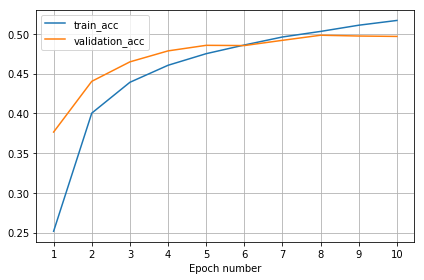

In [16]:
# loss: 4.0225 - categorical_accuracy: 0.2516 - val_loss: 3.0616 - val_categorical_accuracy: 0.3764
# loss: 2.9282 - categorical_accuracy: 0.4002 - val_loss: 2.6586 - val_categorical_accuracy: 0.4402
# loss: 2.6388 - categorical_accuracy: 0.4390 - val_loss: 2.5191 - val_categorical_accuracy: 0.4647
# loss: 2.4811 - categorical_accuracy: 0.4604 - val_loss: 2.4421 - val_categorical_accuracy: 0.4785
# loss: 2.3724 - categorical_accuracy: 0.4750 - val_loss: 2.4010 - val_categorical_accuracy: 0.4855
# loss: 2.2877 - categorical_accuracy: 0.4859 - val_loss: 2.3823 - val_categorical_accuracy: 0.4852
# loss: 2.2160 - categorical_accuracy: 0.4960 - val_loss: 2.3685 - val_categorical_accuracy: 0.4918
# loss: 2.1569 - categorical_accuracy: 0.5030 - val_loss: 2.3513 - val_categorical_accuracy: 0.4982
# loss: 2.1002 - categorical_accuracy: 0.5108 - val_loss: 2.3586 - val_categorical_accuracy: 0.4972
# loss: 2.0550 - categorical_accuracy: 0.5168 - val_loss: 2.3705 - val_categorical_accuracy: 0.4967

train_acc = [0.2516, 0.4002, 0.4390, 0.4604, 0.4750, 0.4859, 0.4960, 0.5030, 0.5108, 0.5168]
val_acc = [0.3764, 0.4402, 0.4647, 0.4785, 0.4855, 0.4852, 0.4918, 0.4982, 0.4972, 0.4967]

# data = [train_acc, val_acc]

fig, ax = draw_figure([train_acc], 'train_acc')
fig, ax = draw_figure([val_acc], 'validation_acc', fig, ax)

ax.grid('on')
fig.tight_layout() 
plt.xticks(np.arange(1, 11))
fig.savefig('train_val.pdf')
plt.show()